In [1]:
"""
Implementation of the Improved LBDT technique
Yuan et al. 2018 An Algorthim for Autoamted Identification of Gust Fronts from Doppler Radar Data. J. Met. Res.
"""

'\nImplementation of the Improved LBDT technique\nYuan et al. 2018 An Algorthim for Autoamted Identification of Gust Fronts from Doppler Radar Data. J. Met. Res.\n'

In [1]:
import os
from datetime import datetime as dt
import math
from multiprocessing import Pool

import netCDF4
import numpy as np

import matplotlib.pyplot as plt

from scipy import ndimage
from skimage import morphology, draw
from sklearn.decomposition import PCA

import helper_functions as util


In [74]:
def find_ridges_new(image_index):
    """
    Equation (2) from Yuan et al. 2018
    """
    #extract refl data
    refl_img_full = refl_data[image_index, :,:]
    #crop to valid data
    refl_img_crop = refl_img_full[:, x_start:] 
    
    #smooth image
    refl_img_prep = ndimage.filters.gaussian_filter(refl_img_crop, 0.5)

    #valid reflectivity mask
    valid_refl_mask = np.logical_and(refl_img_prep>=min_refl, refl_img_prep<=max_refl)
    #convolution filers filter
    g2_size    = 4*n_parm + 3
    conv_filt = ndimage.uniform_filter(refl_img_prep, size=g2_size, mode='constant', cval=min_value)
    #foreground mask
    ridges_mask  = np.logical_and(refl_img_prep > conv_filt, valid_refl_mask)
    
    
    return ridges_mask, refl_img_prep, refl_img_crop

def find_ridges_old(image_index):
    
    #extract refl data
    refl_img_full = refl_data[image_index, :,:]

    #crop to valid data
    refl_img_crop = refl_img_full[:, x_start:] 

    #discreise reflectivity
    refl_img_int = util.refl_to_int(refl_img_crop)

    #valid reflectivity mask
    valid_refl_mask = np.logical_and(refl_img_int>=min_refl, refl_img_int<=max_refl)

    #g1 and g2 convolution filers filter
    g1_size    = 2*n_parm + 1
    g2_size    = 4*n_parm + 3
    conv_g1    = ndimage.uniform_filter(refl_img_int, size=g1_size, mode='constant', cval=min_value)
    conv_g2    = ndimage.uniform_filter(refl_img_int, size=g2_size, mode='constant', cval=min_value)

    #foreground mask
    inital_mask = np.logical_and(refl_img_int >= conv_g1, refl_img_int > conv_g2)
    ridges_mask = np.logical_and(inital_mask, valid_refl_mask)
    
    return ridges_mask, refl_img_int, refl_img_crop


def ridges_to_skeleton(ridges_mask):

    #Smooth Ridge Regions
    dilation_filter = np.array([[0,1,0],[1,1,1],[0,1,0]], np.uint8) #use circular filter shape
    ridges_mask = morphology.binary_dilation(ridges_mask, dilation_filter)
    
    #remove ridge regions by maximum length
    label_ridges_image, n_features = morphology.label(ridges_mask, neighbors=8, background=False, return_num=True, connectivity=1)
    for label_idx in np.arange(1,n_features):
        #calculate bounding box length
        [i_coord, j_coord] = np.where(label_ridges_image==label_idx)
        bb_length = np.sqrt((np.max(i_coord) - np.min(i_coord))**2 + (np.max(j_coord) - np.min(j_coord))**2)
        if bb_length < min_length:
            ridges_mask[label_ridges_image==label_idx] = False
    
    #################################
    # STEP 3: Generate Skeleton
    #################################     
    skeleton = morphology.thin(ridges_mask)
    
    return skeleton, ridges_mask

def remove_intersections(skeleton):

    """
    Remove intersections from skeleton using LBP technique (section 2.4.1)
    """
    
    #pass 1: remove most intersections
    n3_conv_pass1  = ndimage.generic_filter(skeleton.astype(int), util.lbp_filter, footprint=n3_window, mode='constant', cval=0)
    n5_conv_pass1  = ndimage.generic_filter(skeleton.astype(int), util.lbp_filter, footprint=n5_window, mode='constant', cval=0)
    #find
    xsec_point_mask1 = np.logical_and(n3_conv_pass1>=6, n5_conv_pass1>=6) #if n3 or n5 contain 6 changes, then it's an intersection
    xsec_point_mask1[skeleton==False] = False

    #break skeleton at intersection points
    skeleton[xsec_point_mask1] = False

    #pass 2: remove diagonal connecting points left over from T junctions (also removes any burrs)
    n3_conv_pass2 = ndimage.generic_filter(skeleton.astype(int), util.lbp_filter, footprint=n3_window, mode='constant', cval=0)
    xsec_point_mask2 = np.logical_and(n3_conv_pass2>=6, skeleton) #if n3 or n5 contain 6 changes, then it's an intersection
    
    #skeleton[ndimage.morphology.binary_dilation(xsec_point_mask, dilation_filter)] = False
    skeleton[xsec_point_mask2] = False
    #combine xsec masks
    xsec_point_mask = np.logical_or(xsec_point_mask1, xsec_point_mask2)
    
    return skeleton, xsec_point_mask


def remove_turning_points(skeleton):
    
    """
    remove turning points by checking rate of turning across line segments (section 2.4.1)
    """    
    turn_point_mask = np.zeros_like(skeleton, dtype=bool)
    #run labelling
    label_image, n_features = morphology.label(skeleton, neighbors=8, background=False, return_num=True, connectivity=1)
    #for each label
    for label_idx in np.arange(1,n_features):
        #remove short segments
        label_count = np.sum([label_image==label_idx])
        #skip features smaller than the filter
        if label_count < (turnpt_vlen*2 + 1):
            #skeleton[label_image == label_idx] = False
            continue
            
        # extract line points
        i_pts, j_pts = np.where(label_image==label_idx)
        points = np.c_[i_pts, j_pts]
        # compute order of shortest line along points
        opt_order = util.order_points(points)
        points = points[opt_order]
        #compute turning angles
        try:
            #compute turning angles
            out_deg = util.vector_pair_angle(points[:,1], points[:,0], turnpt_vlen)
            #apply masking
            turning_pt_idx = np.where(out_deg < turnpt_angle_threshold)[0] + turnpt_vlen
            turn_point_mask[points[turning_pt_idx,0],points[turning_pt_idx,1]] = True
        except Exception as e:
            print('turning point calc exception')
            pass
    
    #apply turning point_mask
    skeleton[turn_point_mask] = False
    
    return skeleton, turn_point_mask

def find_end_points_and_theta(skeleton):
    
    #find theta
    end_point_theta = np.zeros_like(skeleton, dtype=float)
    end_point_theta.fill(np.nan)
    #run labelling
    label_image, n_features = morphology.label(skeleton, neighbors=8, background=False, return_num=True, connectivity=1)
    #for each label
    for label_idx in np.arange(1,n_features):
        #remove short segments
        label_count = np.sum([label_image==label_idx])
        #skip features smaller than the filter
        if label_count < connect_calc_minpts + 1:
            skeleton[label_image == label_idx] = False
            continue
        #check for length and adjust maxpts to mid point
        if int(label_count/2) > connect_calc_minpts:
            connect_calc_pts = int(label_count/2)
        else:
            connect_calc_pts = connect_calc_minpts
        # extract line points
        i_pts, j_pts = np.where(label_image==label_idx)
        points = np.c_[i_pts, j_pts]
        # compute order of shortest line along points
        opt_order = util.order_points(points)
        points = points[opt_order]   
        #allocate end point angles using end point and 3rd point from the end
        end_point_theta[points[0,0] , points[0,1]]  = util.line_angle(points, connect_calc_pts)
        end_point_theta[points[-1,0], points[-1,1]] = util.line_angle(np.flip(points, 0), connect_calc_pts) #flip so end point starts array
    
    #find end points using conv filter from intersections
    n3_conv        = ndimage.generic_filter(skeleton.astype(int), util.lbp_filter, footprint=n3_window, mode='constant', cval=0)
    end_point_mask  = n3_conv==2
    end_point_mask[skeleton==False] = False
    
    return skeleton, end_point_mask, end_point_theta

def connect_end_points(skeleton, end_point_mask, end_point_theta, refl_img_prep):
    """
    connect end points using a series of tests for end points and line segment properties (section 2.4.2)
    """
    
    #create end point mask and coord list
    connect_point_mask = np.zeros_like(skeleton, dtype=bool)
    i_pts, j_pts  = np.where(end_point_mask)
    end_points    = np.c_[i_pts, j_pts]

    #create dilated skeleton for checking for creation of new intersections and overlaps with existing skeleton
    dilation_filter  = np.array([[1,1,1],[1,1,1],[1,1,1]], np.uint8) #use circular filter shape
    dilated_skeleton = morphology.binary_dilation(skeleton.copy(), dilation_filter)   

    #init connection point list
    connpt_coord_list  = []
    connpt_weight_list = []
    
    #for each point
    for origin_point in end_points:

        #calc distance
        dist_array = np.sqrt((origin_point[0]-end_points[:,0])**2 + (origin_point[1]-end_points[:,1])**2)*grid_size_km
        #find possible matches
        match_idx_list = np.where(np.logical_and(dist_array>0, dist_array<=connect_dist_max))[0]
        dist_array_set = dist_array[match_idx_list]
        #sort by distance (so closest is processed first)
        sort_idx       = np.argsort(dist_array[match_idx_list])
        match_idx_list = match_idx_list[sort_idx]
        dist_array     = dist_array_set[sort_idx]
        #join new matches
        for i, match_idx in enumerate(match_idx_list):
            #extract i,j coords of test end point for connection
            test_point = end_points[match_idx]
            
            #extract theta of origin and test end point for connection
            a_theta  = end_point_theta[origin_point[0], origin_point[1]] #origin
            b_theta  = end_point_theta[test_point[0], test_point[1]] #test
            #calculate vectors between origin and test
            ab_theta = util.points_angle(origin_point, test_point)
            ba_theta = util.points_angle(test_point, origin_point)
            #cosine similarity tests
            test1 = util.cosine_test(ba_theta, a_theta)
            test2 = util.cosine_test(ab_theta, b_theta)
            test3 = util.cosine_test(b_theta, a_theta)
            #run test
            test_threshold = math.cos(math.radians(cosine_test_val)) # -0.7 test threshold
            if test1 > test_threshold or test2 > test_threshold or test3 > test_threshold:
                continue
        
            #generate line between points
            rr, cc = draw.line(origin_point[0], origin_point[1], test_point[0], test_point[1])

            #check for crossing existing skeleton or creating new intersections (using a dilated skeleton)
            line_skeleton = dilated_skeleton[rr, cc]
            if np.sum(line_skeleton)>4: #remember, we are using a dilated skeleton, so a correct connection will have an overlap of 4
                continue

            #check for crossing new connections
            line_connect = connect_point_mask[rr, cc]
            if np.any(line_connect):
                continue
                
            #check for reflectivity limits
            line_refl     = refl_img_prep[rr, cc]
            if np.any(line_refl<min_line_refl) or np.any(line_refl>max_line_refl):
                continue
                
            #print('connection added')
            #connect_point_mask[rr, cc] = True
            connpt_coord_list.append(np.array([rr,cc]).T)
            connpt_weight_list.append(dist_array[i])
            break
            
    #################    
    #rank overlapping conn_points by min distance
    process_flag = np.zeros_like(connpt_coord_list, dtype=bool)
    for i, conn_pt in enumerate(connpt_coord_list):
        #check if already processed
        if process_flag[i]:
            continue
        #mark as processed
        process_flag[i] = True
        #find overlapping arrays
        overlap_idx  = [i] 
        overlap_dist = [connpt_weight_list[i]]
        for j, test_pt in enumerate(connpt_coord_list):
            if process_flag[j]:
                continue
            elif util.coor_intersect_test(conn_pt,test_pt):
                overlap_idx.append(j)
                overlap_dist.append(connpt_weight_list[j])
        if len(overlap_idx) == 1: #no overlaps
            connect_point_mask[conn_pt[:,0], conn_pt[:,1]] = True
        else:
            #find index of min distance connection
            min_idx = np.argmin(overlap_dist)
            conn_idx = overlap_idx[min_idx]
            #apply to connect mask
            connect_point_mask[connpt_coord_list[conn_idx][:,0], connpt_coord_list[conn_idx][:,1]] = True
            #flag all points as processed
            process_flag[overlap_idx] = True
                
        
    #end_point_theta[connect_point_mask] = np.nan
    skeleton[connect_point_mask] = True
    
    return skeleton, connect_point_mask

def remove_short_lines(skeleton):
    """
    Remove regions smaller than min_length
    """
    #run labelling
    label_image, n_features = morphology.label(skeleton, neighbors=8, background=False, return_num=True, connectivity=1)
    #for each label
    for label_idx in np.arange(1,n_features):
        #remove short segments
        label_count = np.sum([label_image==label_idx])
        #skip features smaller than the filter
        if label_count < final_min_length:
            skeleton[label_image == label_idx] = False
            continue
            
    return skeleton

def filter_edges_radialnoise(skeleton, refl_img_prep):
  
    """
    remove line segments that are part of reflectivity edges and remove radial noise (section 2.5)_
    """
    #label image and remove by pixel count and 95th percentile
    label_image, n_features = morphology.label(skeleton, neighbors=8, background=False, return_num=True, connectivity=1)
    for label_idx in np.arange(1,n_features):

        #calculate PCA for line
        i_idx, j_idx = np.where(label_image==label_idx)
        line_points  = np.column_stack((i_idx, j_idx))
        pca = PCA(n_components=2).fit(line_points)
        feature_vectors = pca.components_.T
        nvec            = feature_vectors[1] #use second PCA component for the unit normal vector
            
        #run filter on line segment
        a0, b0 = util.edge_filter_wrapper(refl_img_prep, nvec, line_points)
        
        #contine if a true ridge
        if a0 > 2.5 and b0 > 2.5:
            continue
        # if a0 < edge_filter_threshold and b0 < edge_filter_threshold:
        #     continue
        
        #remove line if it fails this test
        skeleton[label_image == label_idx] = False
    
    return skeleton

def skeleton_to_thinlines(skeleton, ridges_mask):
    """
    preserve thin lines
    """
    thinlines_mask = np.zeros_like(ridges_mask, dtype=bool)
    #run labelling
    label_image, n_features = morphology.label(ridges_mask, neighbors=8, background=False, return_num=True, connectivity=1)
    #for each label
    for label_idx in np.arange(1,n_features):
        #check if ridge feature contains a skeleton
        if np.any(skeleton[label_image == label_idx]):
            thinlines_mask[label_image == label_idx] = True
            
    return thinlines_mask    
    

In [75]:
def generate_plot_simple(refl_img_prep, refl_img_crop, thinlines_mask, initial_skeleton, 
                  xsec_point_mask, turn_point_mask, end_point_mask, 
                  end_point_theta, connect_point_mask, final_skeleton, image_index):
    """
    plotting routine for boundary detection
    """
    #setup figure
    figsize = (20, 10)
    plt.clf()
    fig = plt.figure(facecolor='white', figsize=figsize)
    
    #subplot 1
    ax0 = plt.subplot(1,2,1)
    #add image
    im0 = ax0.imshow(refl_img_prep.astype('float'))
    #add initial skeleton
    [line_i, line_j] = np.where(initial_skeleton)
    ax0.plot(line_j, line_i, 'w.', markersize=ridge_markersz)
    #overlay xsection
    [line_i, line_j] = np.where(xsec_point_mask)
    ax0.plot(line_j, line_i, 'k.', markersize=feat_markersz)    
    #overlay turning points
    [line_i, line_j] = np.where(turn_point_mask)
    ax0.plot(line_j, line_i, 'r*', markersize=feat_markersz)   
    #overlay end points
    [line_i, line_j] = np.where(end_point_mask)
    ax0.plot(line_j, line_i, 'wo', markersize=feat_markersz)  
    #overlay end point vectors
    end_point_mask = ~(np.isnan(end_point_theta))
    [end_i, end_j] = np.where(end_point_mask)
    for i,_ in enumerate(end_i):
        angle = math.radians(end_point_theta[end_i[i], end_j[i]])
        angle_int = int(end_point_theta[end_i[i], end_j[i]])
        plt.arrow(end_j[i], end_i[i], 4.5*math.cos(angle), 4.5*math.sin(angle))
        #plt.text(end_j[i], end_i[i], str(angle_int), color='w',size=15)
    ax0.plot(end_j, end_i, 'wo', markersize=feat_markersz)
    #overlay connection points
    [line_i, line_j] = np.where(connect_point_mask)
    ax0.plot(line_j, line_i, 'yo', markersize=feat_markersz_connect)   
    #ax0.set_title('Reflectivity')
    #fig.colorbar(im0, ax=ax0)
    #zoom if required
    if zoom:
        ax0.set_ylim(zoom_y)
        ax0.set_xlim(zoom_x)
        
    #subplot 2
    ax1 = plt.subplot(1,2,2)
    #plot reflectivity
    im1 = ax1.imshow(refl_img_crop.astype('float'))
    #overlay final skeleton
    [line_i, line_j] = np.where(final_skeleton)
    ax1.plot(line_j, line_i, 'w.', markersize=ridge_markersz)   
    if zoom:
        ax1.set_ylim(zoom_y)
        ax1.set_xlim(zoom_x)
        
    #save
    if save_flag:
        image_ffn = output_path_simple + '/' + str(image_index).zfill(3) + '.png'
        plt.tight_layout()
        plt.savefig(image_ffn, dpi=100)

In [76]:
def generate_plot_full(refl_img_prep, refl_img_crop,
                            initial_skeleton,
                            xsec_skeleton, xsec_point_mask,
                            turn_skeleton, turn_point_mask, 
                            end_point_skeleton, end_point_mask, end_point_theta,
                            conn_skeleton, connect_point_mask,
                            clean_skeleton,
                            filter_skeleton,
                            image_index):
    """
    plotting routine for boundary detection
    """
    #setup figure
    figsize = (20, 40)
    plt.clf()
    fig = plt.figure(facecolor='white', figsize=figsize)
    
    ##subplot 1 - inital
    ax1 = plt.subplot(3,2,1)
    ax1.set_title('Inital Skeleton')
    im1 = ax1.imshow(refl_img_prep.astype('float'))
    #add skeleton
    [line_i, line_j] = np.where(initial_skeleton)
    ax1.plot(line_j, line_i, 'w.', markersize=ridge_markersz)
    
    ##subplot 2- xsec
    ax2= plt.subplot(3,2,2)
    ax2.set_title('Xsec Points')
    im2 = ax2.imshow(refl_img_prep.astype('float'))
    #add skeleton
    [line_i, line_j] = np.where(xsec_skeleton)
    ax2.plot(line_j, line_i, 'w.', markersize=ridge_markersz)
    #overlay xsection
    [line_i, line_j] = np.where(xsec_point_mask)
    ax2.plot(line_j, line_i, 'k.', markersize=feat_markersz)
        
    ##subplot 3 - turning points
    ax3 = plt.subplot(3,2,3)
    ax3.set_title('Turning Points')
    im3 = ax3.imshow(refl_img_prep.astype('float'))
    #add skeleton
    [line_i, line_j] = np.where(turn_skeleton)
    ax3.plot(line_j, line_i, 'w.', markersize=ridge_markersz)
    #overlay xsection
    [line_i, line_j] = np.where(turn_point_mask)
    ax3.plot(line_j, line_i, 'k.', markersize=feat_markersz)
        
    ##subplot 4 - end points
    ax4 = plt.subplot(3,2,4)
    ax4.set_title('End Points')
    im4 = ax4.imshow(refl_img_prep.astype('float'))
    #add skeleton
    [line_i, line_j] = np.where(end_point_skeleton)
    ax4.plot(line_j, line_i, 'w.', markersize=ridge_markersz)
    #overlay end point vectors
    end_point_mask = ~(np.isnan(end_point_theta))
    [end_i, end_j] = np.where(end_point_mask)
    for i,_ in enumerate(end_i):
        angle = math.radians(end_point_theta[end_i[i], end_j[i]])
        angle_int = int(end_point_theta[end_i[i], end_j[i]])
        ax4.arrow(end_j[i], end_i[i], 4.5*math.cos(angle), 4.5*math.sin(angle))
        #plt.text(end_j[i], end_i[i], str(angle_int), color='w',size=15)
    ax4.plot(end_j, end_i, 'wo', markersize=feat_markersz)
    
    ##subplot 5 - connection points
    ax5 = plt.subplot(3,2,5)
    ax5.set_title('Connections')
    im5 = ax5.imshow(refl_img_prep.astype('float'))
    #add skeleton
    [line_i, line_j] = np.where(conn_skeleton)
    ax5.plot(line_j, line_i, 'w.', markersize=ridge_markersz)
    #overlay xsection
    [line_i, line_j] = np.where(connect_point_mask)
    ax5.plot(line_j, line_i, 'k.', markersize=feat_markersz)    
    ax5.plot(end_j, end_i, 'wo', markersize=feat_markersz)
        
    ##subplot 6 - filter points
    ax6 = plt.subplot(3,2,6)
    ax6.set_title('Clean + Filter')
    im6 = ax6.imshow(refl_img_prep.astype('float'))
    #add skeleton
    [line_i, line_j] = np.where(filter_skeleton)
    ax6.plot(line_j, line_i, 'w.', markersize=ridge_markersz)

    #ax0.set_title('Reflectivity')
    #fig.colorbar(im0, ax=ax0)
    #zoom if required
    if zoom:
        ax1.set_ylim(zoom_y)
        ax1.set_xlim(zoom_x)
        ax2.set_ylim(zoom_y)
        ax2.set_xlim(zoom_x)
        ax3.set_ylim(zoom_y)
        ax3.set_xlim(zoom_x)
        ax4.set_ylim(zoom_y)
        ax4.set_xlim(zoom_x)
        ax5.set_ylim(zoom_y)
        ax5.set_xlim(zoom_x)
        ax6.set_ylim(zoom_y)
        ax6.set_xlim(zoom_x)
        
    #save
    if save_flag:
        image_ffn = output_path_full + '/' + str(image_index).zfill(3) + '.png'
        plt.tight_layout()
        plt.savefig(image_ffn, dpi=100)

In [77]:
def production(image_index):
    
    #convert image to ridges
    if original_lbdt_flag == True:
        ridges_mask_inital, refl_img_prep, refl_img_crop = find_ridges_old(image_index)
    else:
        ridges_mask_inital, refl_img_prep, refl_img_crop = find_ridges_new(image_index)
    #convert ridges to skeleton
    skeleton, ridges_mask_filt = ridges_to_skeleton(ridges_mask_inital)
    #remove intersections from skeleton
    initial_skeleton = skeleton.copy()
    skeleton, xsec_point_mask = remove_intersections(skeleton)
    xsec_skeleton = skeleton.copy()
    #remove turning points from keleton
    skeleton, turn_point_mask = remove_turning_points(skeleton)
    turn_skeleton = skeleton.copy()
    #find end points and angles of end point
    skeleton, end_point_mask, end_point_theta = find_end_points_and_theta(skeleton)
    end_point_skeleton = skeleton.copy()
    #connect end points using end point angles and distances
    skeleton, connect_point_mask = connect_end_points(skeleton, 
                                    end_point_mask, end_point_theta, refl_img_prep)
    conn_skeleton = skeleton.copy()
    #remove short lines from skeleton
    skeleton = remove_short_lines(skeleton)
    clean_skeleton = skeleton.copy()
    #remove reflectivity edges and radial noise
    skeleton = filter_edges_radialnoise(skeleton, refl_img_prep)
    filter_skeleton = skeleton.copy()
    #generate thinlines
    thinlines_mask = skeleton_to_thinlines(skeleton, ridges_mask_inital)
    
    #plot
    if full_plot:
        generate_plot_full(refl_img_prep, refl_img_crop,
                            initial_skeleton,
                            xsec_skeleton, xsec_point_mask,
                            turn_skeleton, turn_point_mask, 
                            end_point_skeleton, end_point_mask, end_point_theta,
                            conn_skeleton, connect_point_mask,
                            clean_skeleton,
                            filter_skeleton,
                            image_index)        
    else:
        generate_plot_simple(refl_img_prep, refl_img_crop, thinlines_mask, initial_skeleton, xsec_point_mask,
                  turn_point_mask, 
                  end_point_mask, end_point_theta, connect_point_mask, filter_skeleton, image_index)

In [78]:
#paths
input_ffn   = '/g/data/kl02/jss548/bonn-project-data/radolan_data/radolan_nc/RX-2013-08-06.nc'
output_path_full = '/g/data/kl02/jss548/bonn-project-data/radolan_png_full'
output_path_simple = '/g/data/kl02/jss548/bonn-project-data/radolan_png_simple'

NCPU        = 15
########################################################
# read daily radolan NC file
########################################################
min_value    = -32.5 #dBZ
grid_size_km = 1 #km

########################################################
# image to ridge mask to skeleton config
########################################################
#dimension limit in x
x_start    = 145 #values in x dim less this this aren't present
n_parm     = 3 #filter config
min_length = 15. #min length for ridge regions (pixels)
min_refl   = 0. #min/min reflectivity mask (dbz)
max_refl   = 30.
original_lbdt_flag = False
########################################################
# remove intersections config
########################################################
#LBP convolution windows
n5_window = np.array([[1,1,1,1,1],
                    [1,0,0,0,1],
                    [1,0,0,0,1],
                    [1,0,0,0,1],
                    [1,1,1,1,1]])
n3_window = np.array([[1,1,1],
                    [1,0,1],
                    [1,1,1]])


########################################################
# remove turning points config
########################################################
#number of points either size target point to calculate line segment vector from
turnpt_vlen = 3 #pixels
# minimum angle before a turning point is created
turnpt_angle_threshold = 120 #deg

########################################################
# end point connecting config
########################################################
#number of points away from the end point to calculate the line segment angle for
connect_calc_minpts = 3 #pixels
#maximum distance for a connection
connect_dist_max = 25 #pixel units
#minimum reflectivity to cross for a connection
min_line_refl    = -25 #dbz
#maximum reflectivity to cross for a connection
max_line_refl    = 40 #dbz
#minimum angle for cosine similarity test
cosine_test_val  = 135 #degrees

########################################################
# edge filter config
########################################################
# Th value for section 2.5.1 (Yuan et al. 2018)
edge_filter_threshold = 0.75
final_min_length = 10
########################################################
# plotting
########################################################

#marker sizes
ridge_markersz = 1
feat_markersz  = 2
feat_markersz_connect = 2

#zoom config
zoom = True
#larger zoom
zoom_x = [400, 600]
zoom_y = [100, 350]
#norther subset
# zoom_x = [500, 550]
# zoom_y = [250, 300]
#southern subset
# zoom_x = [450, 525]
# zoom_y = [100, 200]
full_plot = True

In [72]:
#read daily nc file
with netCDF4.Dataset(input_ffn) as ncid:
    refl_data = np.squeeze(ncid['rx'][:, :, :]).filled(min_value)
    time_list = np.squeeze(ncid['time'][:])
    time_units = ncid.variables['time'].units

<Figure size 432x288 with 0 Axes>

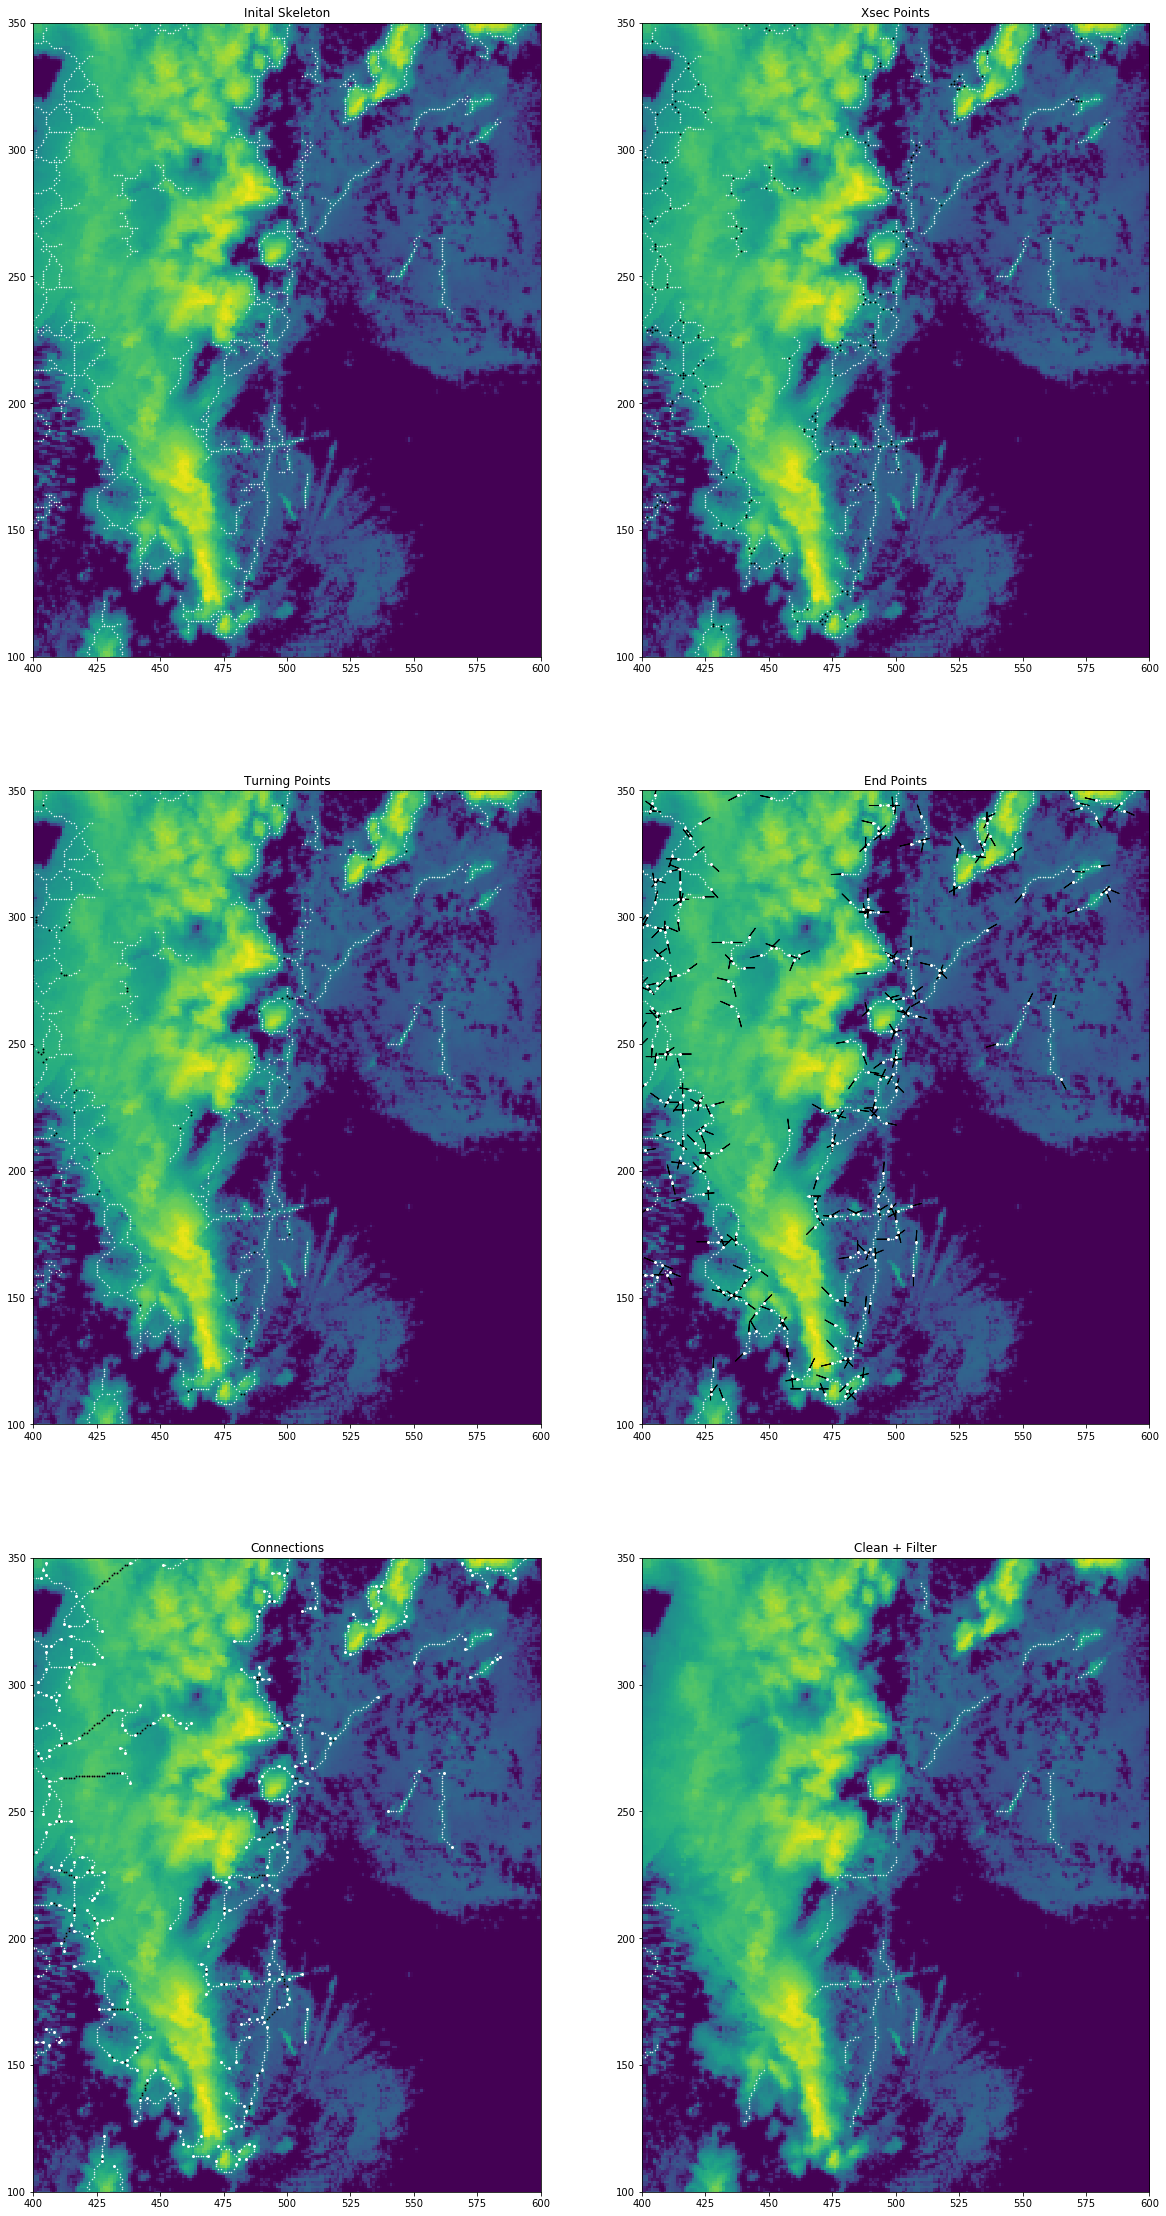

In [79]:
save_flag = False
production(204)

In [80]:
save_flag = True

image_index_list = np.arange(0,len(time_list))

#multiprocessing
chunked_list = util.chunks(image_index_list, NCPU)
i            = 0
n_items      = len(image_index_list)

for one_slice in chunked_list:
    with Pool(NCPU) as pool:
        pool.map(production, one_slice)
        #update user
        i += NCPU
        print('processed: ' + str(round(i/n_items*100, 2)))
        
print('Finished')

# save_flag = True
# for image_index in image_index_list[206:207]:
#     production(image_index)


processed: 5.21
processed: 10.42
processed: 15.62
processed: 20.83
processed: 26.04
processed: 31.25
processed: 36.46
processed: 41.67
turning point calc exception
processed: 46.88
processed: 52.08
processed: 57.29
processed: 62.5
processed: 67.71
processed: 72.92
processed: 78.12
processed: 83.33
processed: 88.54
processed: 93.75
processed: 98.96
processed: 104.17
Finished


In [ ]:
"""
TODO: add radial filter
look at tracking... need to use optical flow on convection then use the motion vectors to track boundaries?

"""

In [82]:
#lets make an animation!

import imageio
import glob

out_path = output_path_full

movie_ffn = out_path + '/movie2.gif'
filenames = sorted(glob.glob(out_path + '/*.png'))[200:220]

with imageio.get_writer(movie_ffn, mode='I', fps=1) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        print('added', filename)
print('finished', movie_ffn)

added /g/data/kl02/jss548/bonn-project-data/radolan_png_full/200.png
added /g/data/kl02/jss548/bonn-project-data/radolan_png_full/201.png
added /g/data/kl02/jss548/bonn-project-data/radolan_png_full/202.png
added /g/data/kl02/jss548/bonn-project-data/radolan_png_full/203.png
added /g/data/kl02/jss548/bonn-project-data/radolan_png_full/204.png
added /g/data/kl02/jss548/bonn-project-data/radolan_png_full/205.png
added /g/data/kl02/jss548/bonn-project-data/radolan_png_full/206.png
added /g/data/kl02/jss548/bonn-project-data/radolan_png_full/207.png
added /g/data/kl02/jss548/bonn-project-data/radolan_png_full/208.png
added /g/data/kl02/jss548/bonn-project-data/radolan_png_full/209.png
added /g/data/kl02/jss548/bonn-project-data/radolan_png_full/210.png
added /g/data/kl02/jss548/bonn-project-data/radolan_png_full/211.png
added /g/data/kl02/jss548/bonn-project-data/radolan_png_full/212.png
added /g/data/kl02/jss548/bonn-project-data/radolan_png_full/213.png
added /g/data/kl02/jss548/bonn-pro